# 1.1. Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:
    - качество предсказания;
    - скорость предсказания;
    - время обучения.

# 1.2. Описание данных

        Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя\
       Целевой признак
- Price — цена (евро)

# 2.1. Подготовка данных

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [153]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [154]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [114]:
df = df.drop(np.where(df['RegistrationYear'] >2020)[0])

In [115]:
df = df.drop(np.where(df['RegistrationYear'] < 1910)[0])

In [116]:
df.Price.isna().sum()

0

Text(0.5, 1.0, 'Registration Year')

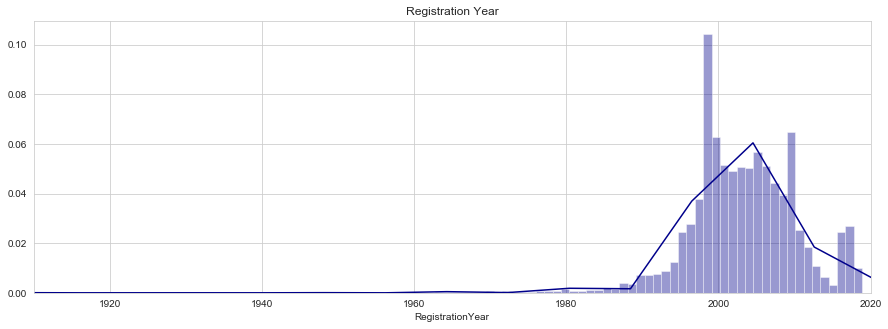

In [117]:
plt.figure(figsize=(15,5))
ax = sns.distplot(df.RegistrationYear, color='darkblue', bins=100, hist_kws={"range": [1910,2020]})
ax.set_xlim(1910, 2020)
plt.title('Registration Year')

Text(0.5, 1.0, 'Price per Auto')

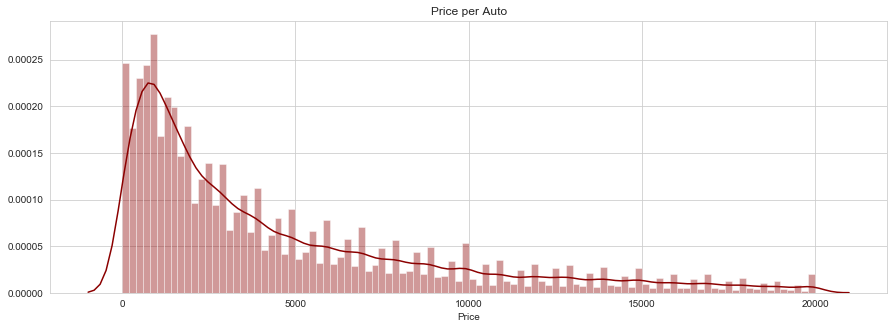

In [118]:
plt.figure(figsize=(15,5))
sns.distplot(df.Price,bins=100, color='darkred')
plt.title('Price per Auto')

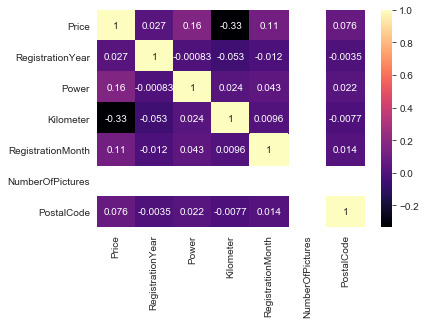

In [155]:
sns.heatmap(df.corr(), annot=True, cmap='magma')

In [120]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [121]:
df.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1, inplace=True)

In [122]:
df[(df['Power']<=30)|(df['Power']>=700)] =-1

In [123]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [124]:
df = df.fillna('unknown')

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354198 non-null  int64 
 1   VehicleType       354198 non-null  object
 2   RegistrationYear  354198 non-null  int64 
 3   Gearbox           354198 non-null  object
 4   Power             354198 non-null  int64 
 5   Model             354198 non-null  object
 6   Kilometer         354198 non-null  int64 
 7   FuelType          354198 non-null  object
 8   Brand             354198 non-null  object
 9   NotRepaired       354198 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


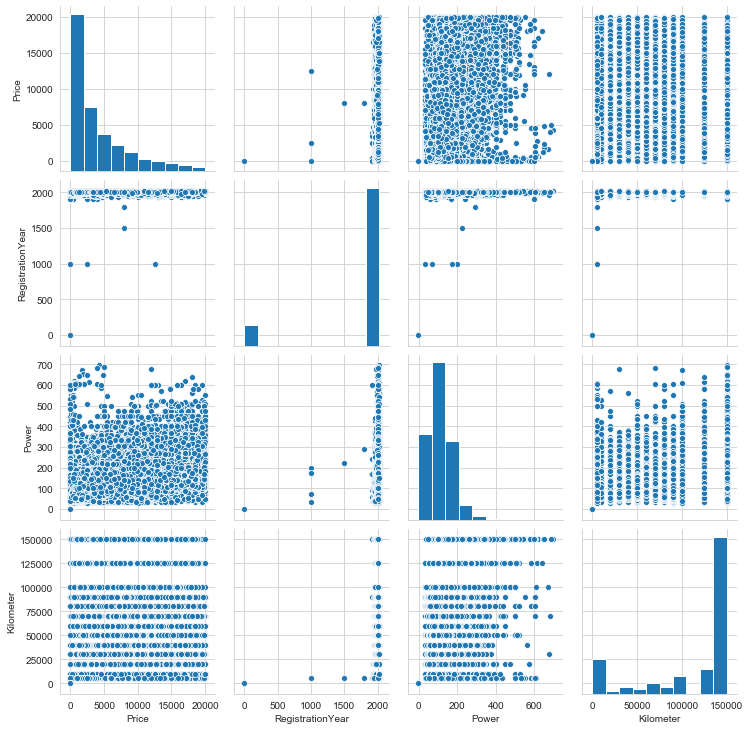

In [126]:
sns.pairplot(df)

Распределение стоимостей похоже на пуассоновское.\
Пробег чаще большой - поддержанных машин продают в разы больше, чем новых из салона. 

Text(0.5, 1.0, '# of VehicleType')

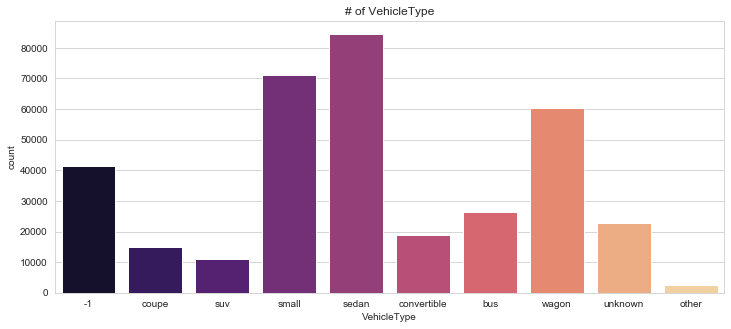

In [127]:
plt.figure(figsize=(12,5))
sns.countplot(df.VehicleType, palette='magma')
plt.title('# of VehicleType')

Мы видим, что самый популярный тип продаваемых машин - седан, затем идет small, на 3 месте - универсал (wagon). \
Также довольно заметное количество автомобилей не имели названия типа, поэтому мы заменили их на невозможное значение: -1

Таким образом, мы импортировали исходные данные.
Удалили данные, в которых год регистрации >2020 и <1910 (невозможные значения годов выпуска машин)\
Также мы удалили строки с нулевой ценой, т.к. учитывать такие данные в нашей модели - бесполезно;\
Заменили значением -1 невозможные мощности двигателя - Power (менее 30 и более 700); \
Исключили столбцы, не имеющие прямого влияния на цену автомобиля
('DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen').

# 2.2. Обучение модели

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor 

In [129]:
X = df.drop('Price',axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [130]:
cat_features = ['VehicleType','RegistrationYear', 'Gearbox','Power', 'Model','Kilometer','FuelType', 'Brand', 'NotRepaired']

In [131]:
catboost = CatBoostRegressor(loss_function='RMSE', iterations=50)

In [132]:
catboost.fit(X_train,y_train,cat_features=cat_features, verbose=10)

Learning rate set to 0.5
0:	learn: 3359.1342361	total: 124ms	remaining: 6.07s
10:	learn: 2011.8525894	total: 964ms	remaining: 3.42s
20:	learn: 1919.8554639	total: 1.84s	remaining: 2.54s
30:	learn: 1879.3481727	total: 2.67s	remaining: 1.64s
40:	learn: 1844.5115949	total: 3.79s	remaining: 831ms
49:	learn: 1824.2700518	total: 4.49s	remaining: 0us


In [133]:
prediction = catboost.predict(X_test)

In [134]:
rmse = np.sqrt(mean_squared_error(y_test,prediction))
rmse

1814.9897429274292

Попробуем пофитить модель с другими гиперпараметрами ( изменим функцию потерь и количество итераций)

In [135]:
catboost2 = CatBoostRegressor(loss_function='MAE',iterations=100)

In [136]:
catboost2.fit(X_train,y_train,cat_features=cat_features, verbose=10)

0:	learn: 3220.4921322	total: 205ms	remaining: 20.3s
10:	learn: 2652.8354166	total: 2s	remaining: 16.2s
20:	learn: 2257.1078575	total: 3.33s	remaining: 12.5s
30:	learn: 1992.3263342	total: 4.34s	remaining: 9.66s
40:	learn: 1825.9478732	total: 5.41s	remaining: 7.79s
50:	learn: 1711.5025618	total: 6.67s	remaining: 6.41s
60:	learn: 1619.9012670	total: 8.93s	remaining: 5.71s
70:	learn: 1521.2058221	total: 10.8s	remaining: 4.41s
80:	learn: 1461.6838896	total: 11.8s	remaining: 2.78s
90:	learn: 1426.4698378	total: 12.8s	remaining: 1.27s
99:	learn: 1402.5558439	total: 13.8s	remaining: 0us


In [137]:
prediction2 = catboost2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,prediction2))
rmse

2396.9095813728354

In [138]:
catboost3 = CatBoostRegressor(loss_function='MAPE',iterations=100)

In [139]:
catboost3.fit(X_train,y_train,cat_features=cat_features, verbose=10)

0:	learn: 0.8852837	total: 356ms	remaining: 35.2s
10:	learn: 0.8796705	total: 2.21s	remaining: 17.9s
20:	learn: 0.8755277	total: 3.13s	remaining: 11.8s
30:	learn: 0.8724710	total: 3.99s	remaining: 8.88s
40:	learn: 0.8702111	total: 4.92s	remaining: 7.08s
50:	learn: 0.8685458	total: 5.81s	remaining: 5.58s
60:	learn: 0.8673173	total: 6.72s	remaining: 4.3s
70:	learn: 0.8664117	total: 7.59s	remaining: 3.1s
80:	learn: 0.8657417	total: 8.49s	remaining: 1.99s
90:	learn: 0.8652472	total: 9.29s	remaining: 919ms
99:	learn: 0.8649154	total: 10.6s	remaining: 0us


In [140]:
prediction3 = catboost3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,prediction3))
rmse

6191.10053574591

Как мы видим, наилучшей метрикой функции потерь является RMSE (rmse=1814.98) \
loss_function='MAE', iterations=100: rmse = 2396.91\
loss_function='MAPE', iterations=100: rmse= 6191.1

Построим модель на базе библиотеки LightGBM и сравним с CatBoost

In [141]:
import lightgbm as lgb

/Users/lubava/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [142]:
categ_features = ['VehicleType','RegistrationYear', 'Gearbox','Power', 'Model','Kilometer','FuelType', 'Brand', 'NotRepaired']

In [143]:
for c in categ_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

/Users/lubava/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lubava/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [144]:
lgb_train = lgb.Dataset(X_train, y_train)

In [145]:
params = {'metric': ['rmse']}

In [146]:
lightgbm = lgb.train(params,
                lgb_train, 
                num_boost_round=30,
                valid_sets=[lgb_train],  
                verbose_eval=10)

[10]	training's rmse: 2496.28
[20]	training's rmse: 1917.98
[30]	training's rmse: 1743.91


In [147]:
lgb_prediction = lightgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,lgb_prediction))
rmse

1769.753379741759

In [148]:
params = {'metric': ['mape']}
lightgbm = lgb.train(params,
                lgb_train, 
                num_boost_round=100,
                valid_sets=[lgb_train],  
                verbose_eval=10)

[10]	training's mape: 248.307
[20]	training's mape: 127.265
[30]	training's mape: 81.4057
[40]	training's mape: 65.2928
[50]	training's mape: 59.7719
[60]	training's mape: 57.3219
[70]	training's mape: 56.1289
[80]	training's mape: 56.0132
[90]	training's mape: 55.3172
[100]	training's mape: 54.7146


In [149]:
lgb_prediction2 = lightgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,lgb_prediction2))
rmse

1622.0517147298674

In [150]:
params = {'metric': ['mae']}
lightgbm = lgb.train(params,
                lgb_train, 
                num_boost_round=100,
                valid_sets=[lgb_train],  
                verbose_eval=10)

[10]	training's l1: 1792.81
[20]	training's l1: 1243.53
[30]	training's l1: 1058.3
[40]	training's l1: 987.652
[50]	training's l1: 955.842
[60]	training's l1: 938.402
[70]	training's l1: 926.505
[80]	training's l1: 917.721
[90]	training's l1: 911.018
[100]	training's l1: 904.724


In [151]:
lgb_prediction3 = lightgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,lgb_prediction3))
rmse

1622.0517147298674

# Вывод

Таким образом, мы построили модели на базе библиотек catboost и lightgbm. \
Для трёх наборов гиперпараметров (loss_function='RMSE', iterations=50), \
(loss_function = 'MAE', iterations=100),\
(loss_function=MAPE, iterations=100) -  модели протестированы по точности (метрика RMSE), скорости обучения и предсказания.\
В обоих случаях catboost-модели оказались быстрее по времени предсказания, но менее точными, и более медленными при обучении.